In [1]:
import construction as cs
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


import dynamic_metrics as ds


import matplotlib.pyplot as plt

### read font
from matplotlib import font_manager

font_dirs = ['Barlow/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Barlow'

import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




%load_ext autoreload
%autoreload 2

In [2]:
def compute_probs(data, n=10): 
    data = np.array(data)
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10,js=False): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    E = 0.0000000001
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    p = np.array(p) + E 
    q = np.array(q) + E 
    
    p = p/sum(p)
    q = q/sum(q)
    
    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    if js:
        return js_divergence(p, q)
    else:
        return kl_divergence(p, q)


In [3]:
import os 

# load sir model

In [4]:

def load_r0(file_name,lambds=["la001"],picco=""):
    ori = []
    stb = []
    etn = []
    tag = []
    stm = []
    dym = []
    for lambd in lambds:
        ori.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/orig.npy"))
        stb.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/stab.npy"))
        etn.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/etn.npy"))
        tag.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/tag.npy"))
        stm.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/stm.npy"))
        dym.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0"+picco+"/"+lambd+"/dym.npy"))
        
    #return ori,stb,etn,stm,tag,dym
    #ori,stb,etn,tag,dym stm
    return ori,stb,etn,tag,dym,stm
import math



# example of calculating the kl divergence between two mass functions
from math import log2
from scipy.stats import wasserstein_distance as em
from scipy.stats import ks_2samp



def comp_stat(ori,competitor,dist,names):
    res = dict()
    c = 0
    for met in competitor:
        tmp = []
        for comp in met:
            if dist == "js":
                val = compute_kl_divergence(ori[c], comp, n_bins=50,js=True)
            elif dist == "kl":
                val = compute_kl_divergence(ori[c], comp, n_bins=50,js=False)
            elif dist == "em":
                val = em(ori[c],comp)
            elif dist == "ks":
                val = (ks_2samp(ori[c],comp)[0])
                
            tmp.append(val)
            
        res[names[c]] = (np.mean(tmp),np.std(tmp))
        c = c + 1 
        
    return res
def comp_stat_stb(ori,competitor,dist,names):
    
    res = dict()
    c = 0
    for comp in competitor:
        tmp = []
        if dist == "js":
            val = compute_kl_divergence(ori[c], comp, n_bins=50,js=True)
        elif dist == "kl":
            val = compute_kl_divergence(ori[c], comp, n_bins=50,js=False)
        elif dist == "em":
            val = em(ori[c],comp)
        elif dist == "ks":
            val = (ks_2samp(ori[c],comp)[0])

        tmp.append(val)
            
        res[names[c]] = (np.mean(tmp),np.std(tmp))
        c = c + 1 
        
    return res



def plot_r0(ax,file_name,lambs,picco,dist,stab=False):
    ori,stb,etn,stm,tag,dym = load_r0(file_name,lambds=lambs,picco=picco)
    x1 = np.array(list(comp_stat_stb(ori,stb,dist=dist,names=lambs).values()))
    x2 = np.array(list(comp_stat(ori,etn,dist=dist,names=lambs).values()))
    x3 = np.array(list(comp_stat(ori,stm,dist=dist,names=lambs).values()))
    x4 = np.array(list(comp_stat(ori,tag,dist=dist,names=lambs).values()))
    x5 = np.array(list(comp_stat(ori,dym,dist=dist,names=lambs).values()))



    x = np.arange(3)
    width = 0.2

    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1, capsize=4, capthick=1)

    rects1 = ax.bar(x - 0.3, x2[:,0], width, label='ETN-gen',color=ETN_COLOR, yerr=x2[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, label='STM',color=STM_COLOR, yerr=x3[:,1], error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x4[:,0], width, label='TagGen',color=TAG_COLOR, yerr=x4[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x5[:,0], width, label='Dymond',color=DYM_COLOR, yerr=x5[:,1], error_kw=error_bar_style)
    
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=2, label='Stability',color=ORIGINAL_COLOR)

    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=2, color=ORIGINAL_COLOR)
    ax.plot([2-0.45,2.45],[x1[2],x1[2]],linewidth=2, color=ORIGINAL_COLOR)


    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)

    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)

    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')



    labels = [r"$\lambda$ = 0.25",r"$\lambda$ = 0.15",r"$\lambda$ = 0.01"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))
    
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [5]:
ORIGINAL_COLOR = '#474747' #dark grey
ETN_COLOR =  '#fb7041' #'#E5865E' # arancio
TAG_COLOR = '#96ccc8' # light blue
STM_COLOR = '#bad1f2' #8F2E27' # rosso
DYM_COLOR = '#559ca6' # teal


line_width = 1


In [6]:
p1 = ""
p2 = "_meta"
p3 = "_2picco"
dist = "ks"
lambs = ["la025","la015","la001"]

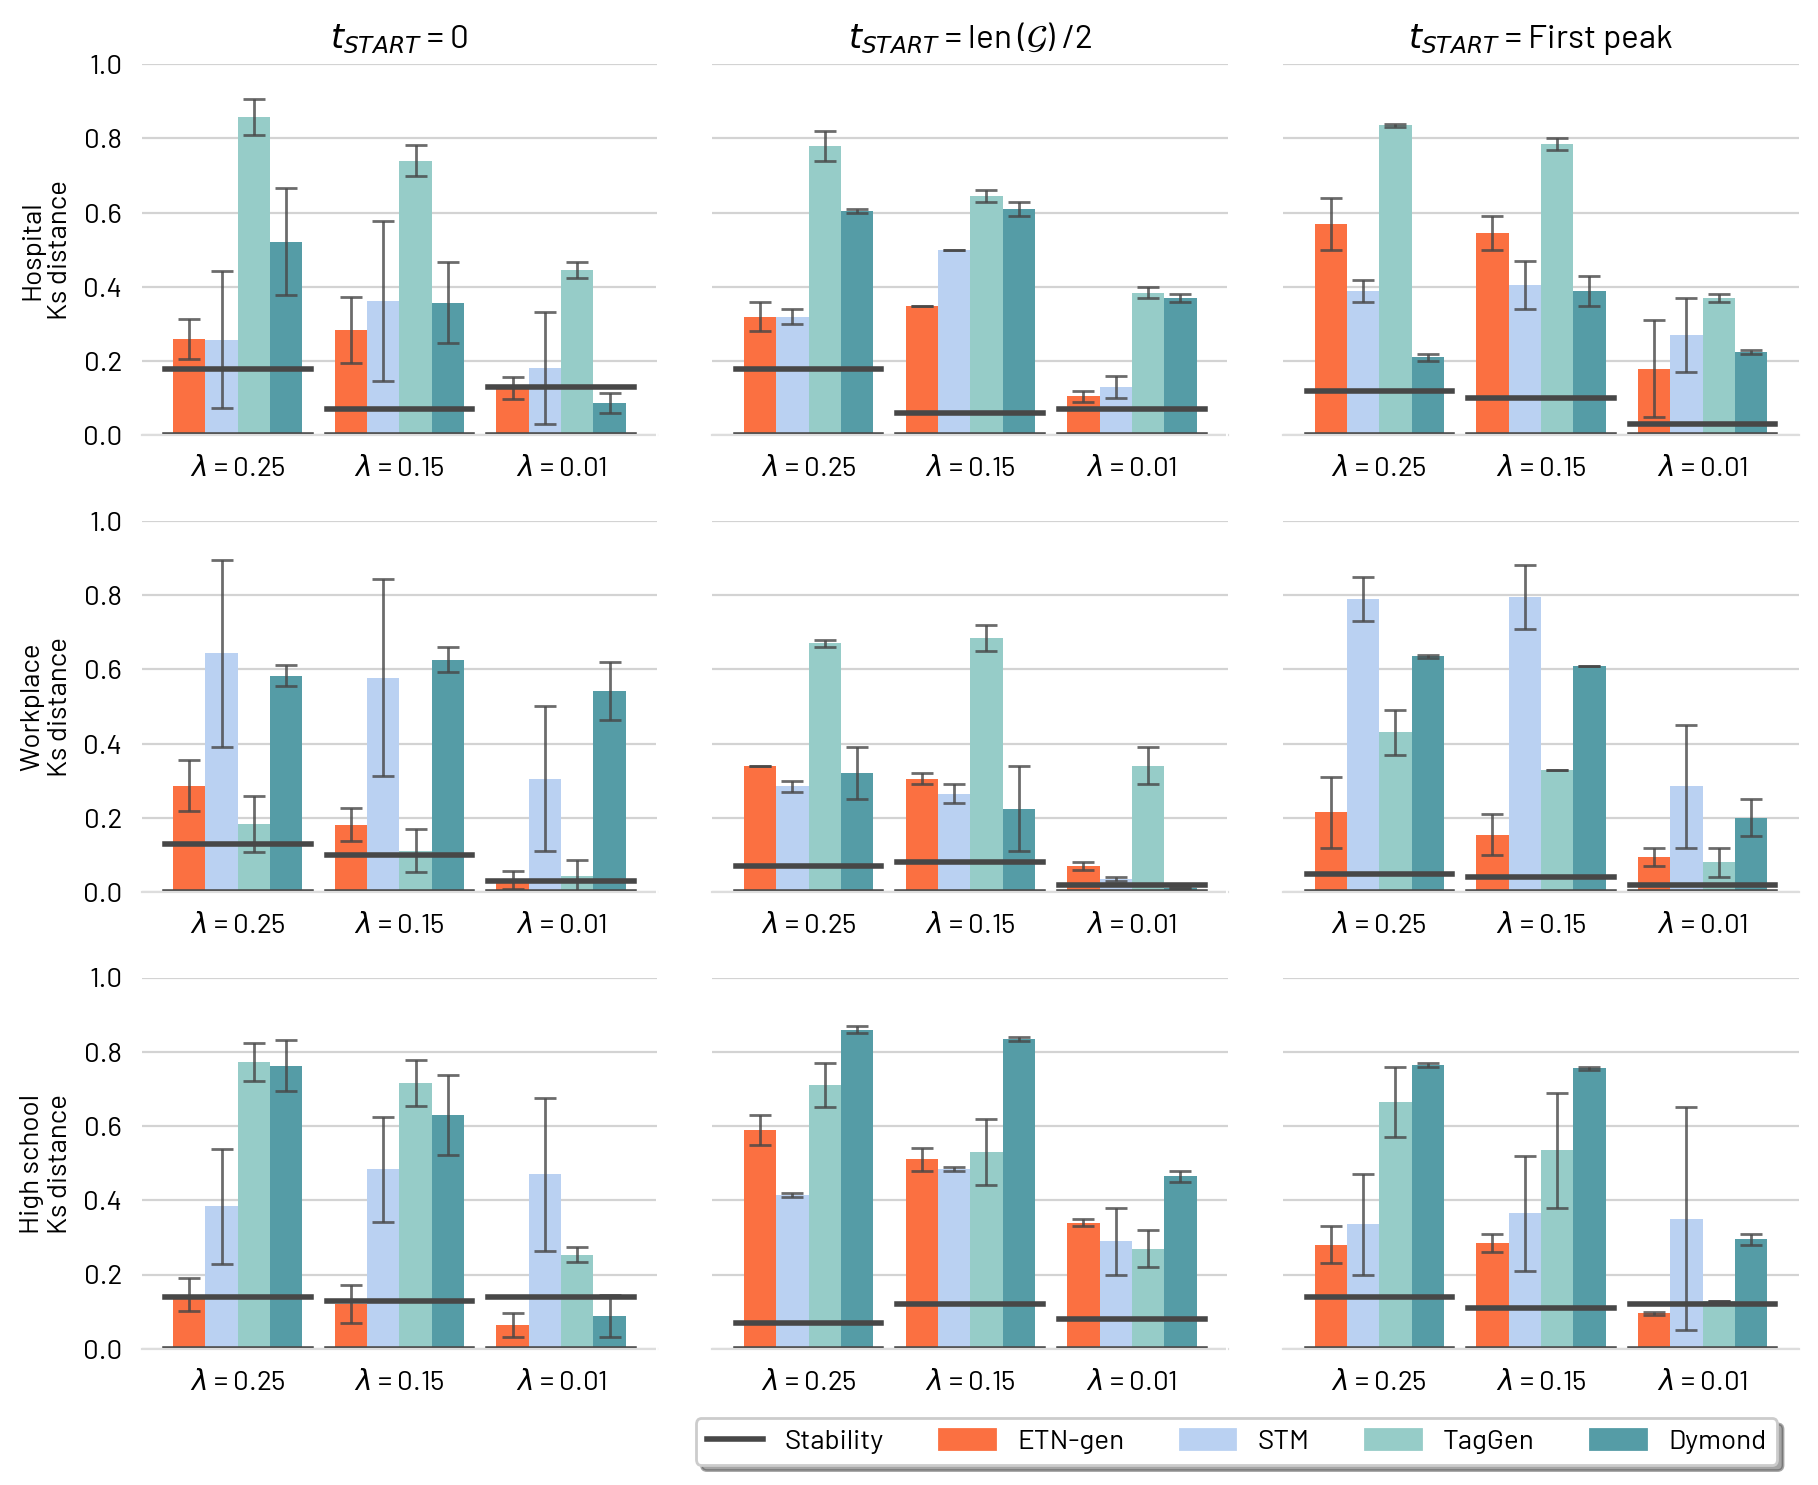

In [7]:
fig, ax = plt.subplots(3,3, figsize=(9,7))
fig.tight_layout(w_pad=-1)

plot_r0(ax[0][0],"LH10",lambs,p1,dist)
plot_r0(ax[0][1],"LH10",lambs,p2,dist)
plot_r0(ax[0][2],"LH10",lambs,p3,dist)
ax[0][0].set_ylabel("Hospital\nKs distance")

plot_r0(ax[1][0],"InVS13",lambs,p1,dist)
plot_r0(ax[1][1],"InVS13",lambs,p2,dist)
plot_r0(ax[1][2],"InVS13",lambs,p3,dist)
ax[1][0].set_ylabel("Workplace\nKs distance")

plot_r0(ax[2][0],"High_School11",lambs,p1,dist)
plot_r0(ax[2][1],"High_School11",lambs,p2,dist)
plot_r0(ax[2][2],"High_School11",lambs,p3,dist,True)
ax[2][0].set_ylabel("High school\nKs distance")

ax[0][1].tick_params(axis='y', colors='white')
ax[0][2].tick_params(axis='y', colors='white')
ax[1][1].tick_params(axis='y', colors='white')
ax[1][2].tick_params(axis='y', colors='white')
ax[2][1].tick_params(axis='y', colors='white')
ax[2][2].tick_params(axis='y', colors='white')

ax[0][0].set_title("$t_{START}$ = 0")
ax[0][1].set_title("$t_{START}$ = len ($\mathcal{G}$) /2")
ax[0][2].set_title("$t_{START}$ = First peak")


custom_lines = [Line2D([0], [0], color=ORIGINAL_COLOR, lw=2, label='Line'),
                Patch(facecolor=ETN_COLOR, edgecolor=ETN_COLOR,label='Color Patch'),
               Patch(facecolor=STM_COLOR, edgecolor=STM_COLOR,label='Color Patch'),
               Patch(facecolor=TAG_COLOR, edgecolor=TAG_COLOR,label='Color Patch'),
               Patch(facecolor=DYM_COLOR, edgecolor=DYM_COLOR,label='Color Patch')]

ax[2][2].legend(custom_lines, ['Stability','ETN-gen', 'STM', 'TagGen', "Dymond"],
               loc='upper center', bbox_to_anchor=(-0.09, -0.15),
          fancybox=True, shadow=True, ncol=5)


fig.savefig("COM_PHY_new_fig/SIR_model_altri_picchi.pdf", bbox_inches = 'tight')

# rw

In [40]:
def load_cov(file_name,p):
    ori_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/orig.npy")
    sta_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/stab.npy")
    etn_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/etn.npy")
    stm_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/stm.npy")
    tag_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/tag.npy")
    dym_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage"+p+"/dym.npy")
    
    return ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov

def load_mfpt(file_name,p):
    ori_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/orig.npy")
    sta_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/stab.npy")
    etn_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/etn.npy",allow_pickle=True)
    stm_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/stm.npy",allow_pickle=True)
    tag_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/tag.npy",allow_pickle=True)
    dym_mfpt = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT"+p+"/dym.npy",allow_pickle=True)
    
    return ori_mfpt,sta_mfpt,etn_mfpt,stm_mfpt,tag_mfpt,dym_mfpt


def compute_cov_mfpt_give_file(file_name,p,fun):

    ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov = fun(file_name,p)

    ec_kl = []
    tc_kl = []
    sc_kl = []
    dc_kl = []
    for i in etn_cov:
        ec_kl.append(ks_2samp(ori_cov,i)[0])
    for i in tag_cov:
        tc_kl.append(ks_2samp(ori_cov,i)[0])
    for i in dym_cov:
        dc_kl.append(ks_2samp(ori_cov,i)[0])
    for i in stm_cov:
        sc_kl.append(ks_2samp(ori_cov,i)[0])

    stb = ks_2samp(ori_cov,sta_cov)[0]

    res = [[stb],
           [np.mean(ec_kl),np.std(ec_kl)],[np.mean(tc_kl),np.std(tc_kl)],
           [np.mean(sc_kl),np.std(sc_kl)],[np.mean(dc_kl),np.std(dc_kl)]]

    #res = [[stb],
    #       [np.mean(ec_kl),np.std(ec_kl)/np.sqrt(len(ec_kl))],[np.mean(tc_kl),np.std(tc_kl)/np.sqrt(len(tc_kl))],
    #       [np.mean(sc_kl),np.std(sc_kl)/np.sqrt(len(sc_kl))],[np.mean(dc_kl),np.std(dc_kl)/np.sqrt(len(dc_kl))]]
    
    return res


def plot_rw(ax,file_name,p):
    cov = compute_cov_mfpt_give_file(file_name,p,load_cov)
    mfpt = compute_cov_mfpt_give_file(file_name,p,load_mfpt)

    x = np.arange(2)

    x1 = np.array([cov[0],mfpt[0]])
    x2 = np.array([cov[1],mfpt[1]])
    x3 = np.array([cov[2],mfpt[2]])
    x4 = np.array([cov[3],mfpt[3]])
    x5 = np.array([cov[4],mfpt[4]])

    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    width = 0.2
    rects1 = ax.bar(x - 0.3, x2[:,0], width, yerr=x2[:,1], label='ETN-gen',color=ETN_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, yerr=x3[:,1], label='STM',color=STM_COLOR, error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, yerr=x5[:,1], label='TagGen',color=TAG_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, yerr=x4[:,1], label='Dymond',color=DYM_COLOR, error_kw=error_bar_style)
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)


    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)

    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)

    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')    

    labels = ["Coverage","MFPT"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))
    
    #ax.set_ylim((0,1))

In [41]:
p1 = ""
p2 = "_meta"
p3 = "_2picco"


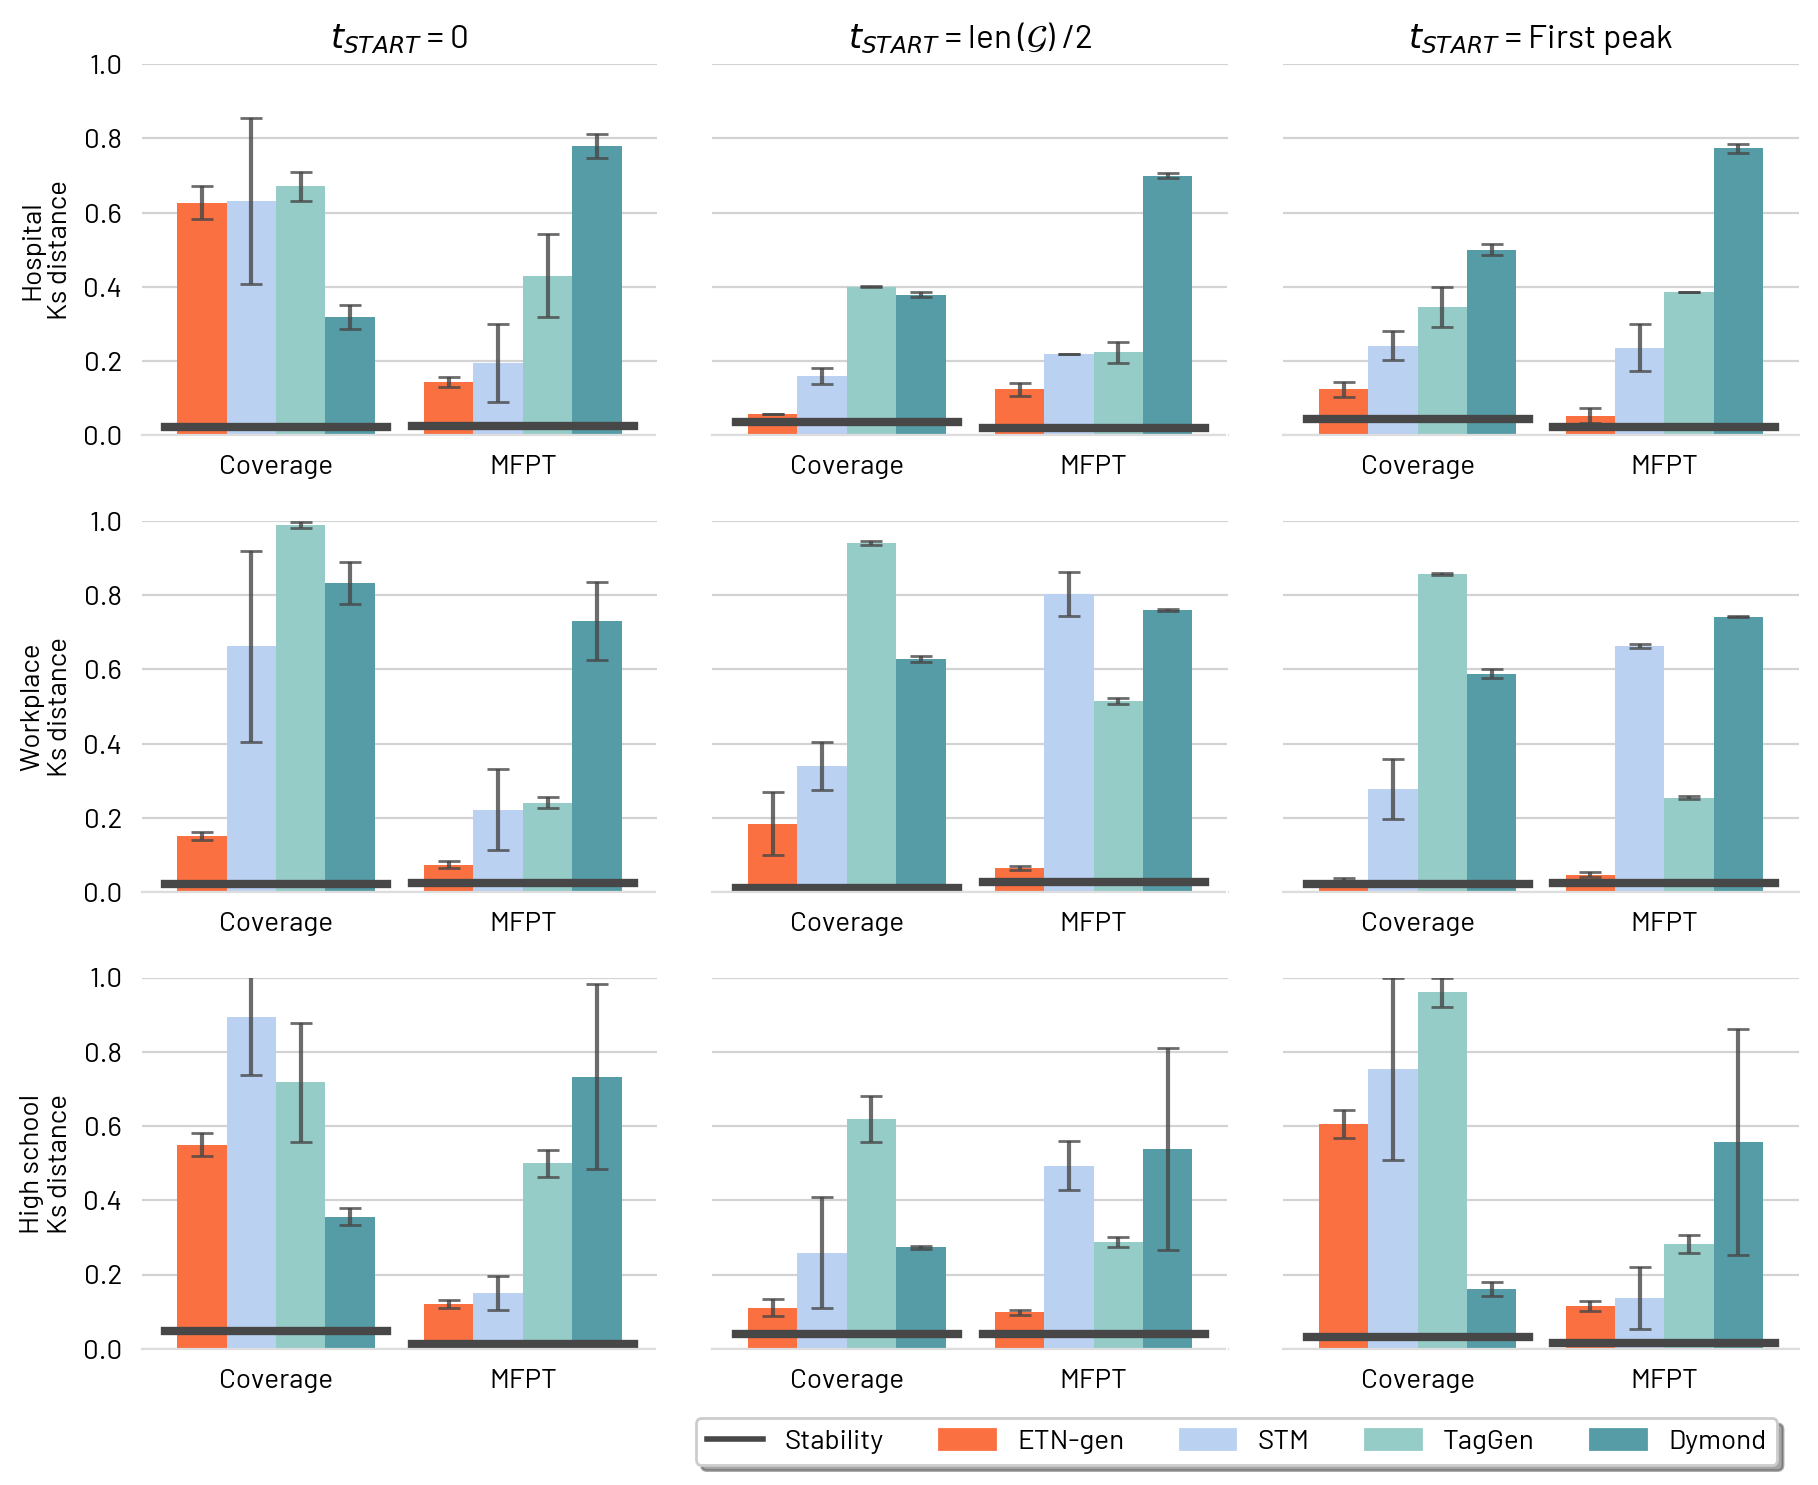

In [46]:
fig, ax = plt.subplots(3,3, figsize=(9,7))
fig.tight_layout(w_pad=-1)


plot_rw(ax[0][0],"LH10",p1)
plot_rw(ax[0][1],"LH10",p2)
plot_rw(ax[0][2],"LH10",p3)


plot_rw(ax[1][0],"InVS13",p1)
plot_rw(ax[1][1],"InVS13",p2)
plot_rw(ax[1][2],"InVS13",p3)


plot_rw(ax[2][0],"High_School11",p1)
plot_rw(ax[2][1],"High_School11",p2)
plot_rw(ax[2][2],"High_School11",p3)




ax[0][0].set_ylabel("Hospital\nKs distance")
ax[1][0].set_ylabel("Workplace\nKs distance")
ax[2][0].set_ylabel("High school\nKs distance")

ax[0][1].tick_params(axis='y', colors='white')
ax[0][2].tick_params(axis='y', colors='white')
ax[1][1].tick_params(axis='y', colors='white')
ax[1][2].tick_params(axis='y', colors='white')
ax[2][1].tick_params(axis='y', colors='white')
ax[2][2].tick_params(axis='y', colors='white')

ax[0][0].set_title("$t_{START}$ = 0")
ax[0][1].set_title("$t_{START}$ = len ($\mathcal{G}$) /2")
ax[0][2].set_title("$t_{START}$ = First peak")


custom_lines = [Line2D([0], [0], color=ORIGINAL_COLOR, lw=2, label='Line'),
                Patch(facecolor=ETN_COLOR, edgecolor=ETN_COLOR,label='Color Patch'),
               Patch(facecolor=STM_COLOR, edgecolor=STM_COLOR,label='Color Patch'),
               Patch(facecolor=TAG_COLOR, edgecolor=TAG_COLOR,label='Color Patch'),
               Patch(facecolor=DYM_COLOR, edgecolor=DYM_COLOR,label='Color Patch')]


ax[2][2].legend(custom_lines, ['Stability','ETN-gen', 'STM', 'TagGen', "Dymond"],
               loc='upper center', bbox_to_anchor=(-0.09, -0.15),
          fancybox=True, shadow=True, ncol=5)



fig.savefig("COM_PHY_new_fig/RW_model_altri_picchi.pdf", bbox_inches = 'tight')

In [ ]:

def plot_cov_mfpt3(ax,file_name,nb_bins=50,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
        
    cov = compute_cov_give_file(file_name,nb_bins)
    mfpt = compute_mfpt_give_file(file_name,nb_bins)
    
    x = np.arange(2)
    
    x1 = np.array([cov[0],mfpt[0]])
    x2 = np.array([cov[1],mfpt[1]])
    x3 = np.array([cov[2],mfpt[2]])
    x4 = np.array([cov[3],mfpt[3]])
    x5 = np.array([cov[4],mfpt[4]])
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    width = 0.2
    rects1 = ax.bar(x - 0.3, x2[:,0], width, yerr=x2[:,1], label='ETN-gen',color=ETN_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, yerr=x3[:,1], label='STM',color=STM_COLOR, error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, yerr=x5[:,1], label='TagGen',color=TAG_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, yerr=x4[:,1], label='Dymond',color=DYM_COLOR, error_kw=error_bar_style)
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
              
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')    
    
    labels = ["Coverage","MFPT"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    #ax.set_ylim((0,1))

# load distributions coverage

k volte, con n0 e t0 random

In [ ]:
def load_cov(file_name):
    ori_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/orig.npy")
    sta_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/stab.npy")
    etn_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/etn.npy")
    stm_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/stm.npy")
    tag_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/tag.npy")
    dym_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/dym.npy")
    
    return ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov

def load_mfpt(file_name):
    ori_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/orig.npy")
    sta_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/stab.npy")
    etn_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/etn.npy",allow_pickle=True)
    stm_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/stm.npy",allow_pickle=True)
    tag_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/tag.npy",allow_pickle=True)
    dym_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/dym.npy",allow_pickle=True)
    
    return ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov


def compute_mfpt_give_file(file_name,nb_bins=50):
    
    ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov = load_mfpt(file_name)
    
    ec_kl = []
    tc_kl = []
    sc_kl = []
    dc_kl = []
    for i in etn_cov:
        ec_kl.append(compute_kl_divergence(ori_cov,i,n_bins=nb_bins))
    for i in tag_cov:
        tc_kl.append(compute_kl_divergence(ori_cov,i,n_bins=nb_bins))
    for i in dym_cov:
        dc_kl.append(compute_kl_divergence(ori_cov,i,n_bins=nb_bins))
    for i in stm_cov:
        sc_kl.append(compute_kl_divergence(ori_cov,i,n_bins=nb_bins))

    stb = compute_kl_divergence(ori_cov,sta_cov,n_bins=nb_bins)

    #res = [[stb],
    #       [np.nanmean(ec_kl),np.nanstd(ec_kl)],[np.nanmean(tc_kl),np.nanstd(tc_kl)],
    #       [np.nanmean(sc_kl),np.nanstd(sc_kl)],[np.nanmean(dc_kl),np.nanstd(dc_kl)]]

    res = [[stb],
           [np.nanmean(ec_kl),np.nanstd(ec_kl)/np.sqrt(len(ec_kl))],[np.nanmean(tc_kl),np.nanstd(tc_kl)/np.sqrt(len(tc_kl))],
           [np.nanmean(sc_kl),np.nanstd(sc_kl)/np.sqrt(len(sc_kl))],[np.nanmean(dc_kl),np.nanstd(dc_kl)/np.sqrt(len(dc_kl))]]
    
    return res

In [ ]:

def load_r0(file_name,lambds=["la001"]):
    ori = []
    stb = []
    etn = []
    tag = []
    stm = []
    dym = []
    for lambd in lambds:
        ori.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/orig.npy"))
        stb.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/stab.npy"))
        etn.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/etn.npy"))
        tag.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/tag.npy"))
        stm.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/stm.npy"))
        dym.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/dym.npy"))

    return ori,stb,etn,stm,tag,dym
    
import math




In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D




def plot_cov_mfpt3(ax,file_name,nb_bins=50,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
        
    cov = compute_cov_give_file(file_name,nb_bins)
    mfpt = compute_mfpt_give_file(file_name,nb_bins)
    
    x = np.arange(2)
    
    x1 = np.array([cov[0],mfpt[0]])
    x2 = np.array([cov[1],mfpt[1]])
    x3 = np.array([cov[2],mfpt[2]])
    x4 = np.array([cov[3],mfpt[3]])
    x5 = np.array([cov[4],mfpt[4]])
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    width = 0.2
    rects1 = ax.bar(x - 0.3, x2[:,0], width, yerr=x2[:,1], label='ETN-gen',color=ETN_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, yerr=x3[:,1], label='STM',color=STM_COLOR, error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, yerr=x5[:,1], label='TagGen',color=TAG_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, yerr=x4[:,1], label='Dymond',color=DYM_COLOR, error_kw=error_bar_style)
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
              
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')    
    
    labels = ["Coverage","MFPT"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    #ax.set_ylim((0,1))

        
def empty_plot(ax):
    
    ax.plot()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])
    


In [ ]:
def plot_r03(ax,file_name,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
    x1,x2,x3,x4,x5 = compute_ks_r0(file_name)
    print(x1)
    x = np.arange(3)
    width = 0.2
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    rects1 = ax.bar(x - 0.3, x2[:,0], width, label='ETN-gen',color=ETN_COLOR, yerr=x2[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, label='STM',color=STM_COLOR, yerr=x3[:,1], error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, label='TagGen',color=TAG_COLOR, yerr=x5[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, label='Dymond',color=DYM_COLOR, yerr=x4[:,1], error_kw=error_bar_style)
    
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([2-0.45,2.45],[x1[2],x1[2]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
          
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    

    labels = [r"$\lambda$ = 0.25",r"$\lambda$ = 0.15",r"$\lambda$ = 0.01"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    #ax.set_ylim((0,1))
    
    if legend:
        c = 0

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(12,3), gridspec_kw={'width_ratios': [1,1,1,0.2,1.5,1.5,1.5]})
fig.tight_layout(w_pad=-1)

ax[0].get_shared_y_axes().join(ax[0], ax[1],ax[2])
ax[4].get_shared_y_axes().join(ax[4], ax[5],ax[6])
plot_cov_mfpt3(ax[0],"LH10")
plot_cov_mfpt3(ax[1],"InVS13")
plot_cov_mfpt3(ax[2],"High_School11",legend=True)

empty_plot(ax[3])

plot_r03(ax[4],"LH10")
plot_r03(ax[5],"InVS13")
plot_r03(ax[6],"High_School11",legend=True)


ax[1].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='y', colors='white')

#ax[4].tick_params(axis='y', colors='white')
ax[5].tick_params(axis='y', colors='white')
ax[6].tick_params(axis='y', colors='white')

legend_elements = [Line2D([0], [0], color=ORIGINAL_COLOR, lw=3,label='Original'),
                   Patch(facecolor=ETN_COLOR, edgecolor=ETN_COLOR,label='ETN-Gen'),
                   Patch(facecolor=STM_COLOR, edgecolor=STM_COLOR,label='STM'),
                   Patch(facecolor=TAG_COLOR, edgecolor=TAG_COLOR,label='TagGen'),
                   Patch(facecolor=DYM_COLOR, edgecolor=DYM_COLOR,label='Dymond')]

# Create the figure
ax[0].legend(handles=legend_elements,loc='center left', bbox_to_anchor=(-0.2, -0.2),ncol=5)

fig.text(0.17, 1.08, 'Random walk',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")
fig.text(0.682, 1.08, 'SIR model',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")


#fig.savefig("dynamic_main_test_kld_TEST2_with_stderror.pdf", bbox_inches = 'tight')

In [ ]:
def one_line_plot(ax,ori,stab,etn,stm,tag,dym):
    #ax[0].figure(figsize=(15,3))
    #ax[0].supset_title(set_title)
    ax[0].hist(ori)
    ax[0].set_title("orig")
    
    ax[1].hist(stab)
    ax[1].set_title("stab")
    
    ax[2].hist(etn[0][0])
    ax[2].set_title("etn")
    
    ax[3].hist(stm[0][0])
    ax[3].set_title("stm")
    
    ax[4].hist(tag[0][0])
    ax[4].set_title("tag")
    
    ax[5].hist(dym[0][0])
    ax[5].set_title("dym")

In [ ]:
filename = "High_School11"
fig, ax = plt.subplots(3,6, figsize=(15,9))

fig.text(0.5, 0.95, filename,fontdict={'size':14,'color':'#4d4d4d'},weight="bold")
fig.text(0.08, 0.2, 'la 0025',fontdict={'size':14,'color':'#4d4d4d'},weight="bold",rotation="vertical")
fig.text(0.08, 0.5, 'la 0015',fontdict={'size':14,'color':'#4d4d4d'},weight="bold",rotation="vertical")
fig.text(0.08, 0.75, 'la 0001',fontdict={'size':14,'color':'#4d4d4d'},weight="bold",rotation="vertical")

ori,stab,etn,stm,tag,dym = load_r0(filename,lambds=["la001"])
one_line_plot(ax[0],ori,stab,etn,stm,tag,dym)
ori,stab,etn,stm,tag,dym = load_r0(filename,lambds=["la015"])
one_line_plot(ax[1],ori,stab,etn,stm,tag,dym)
ori,stab,etn,stm,tag,dym = load_r0(filename,lambds=["la025"])
one_line_plot(ax[2],ori,stab,etn,stm,tag,dym)

#fig.savefig("plot_distributions/dinamic_r0_"+filename+".pdf", bbox_inches = 'tight')

In [ ]:
def one_line_plot(ax,ori,stab,etn,stm,tag,dym):
    #ax[0].figure(figsize=(15,3))
    #ax[0].supset_title(set_title)
    ax[0].hist(ori)
    ax[0].set_title("orig")
    
    ax[1].hist(stab)
    ax[1].set_title("stab")
    
    ax[2].hist(etn[0][0])
    ax[2].set_title("etn")
    
    ax[3].hist(stm[0][0])
    ax[3].set_title("stm")
    
    ax[4].hist(tag[0][0])
    ax[4].set_title("tag")
    
    ax[5].hist(dym[0][0])
    ax[5].set_title("dym")

In [ ]:
filename = "InVS13"
fig, ax = plt.subplots(2,6, figsize=(15,6))

fig.text(0.5, 0.95, filename,fontdict={'size':14,'color':'#4d4d4d'},weight="bold")
fig.text(0.08, 0.2, 'cov',fontdict={'size':14,'color':'#4d4d4d'},weight="bold",rotation="vertical")
fig.text(0.08, 0.7, 'mfpt',fontdict={'size':14,'color':'#4d4d4d'},weight="bold",rotation="vertical")

ori,stab,etn,stm,tag,dym = load_mfpt(filename)
one_line_plot2(ax[0],ori,stab,etn,stm,tag,dym)

ori,stab,etn,stm,tag,dym = load_cov(filename)
one_line_plot2(ax[1],ori,stab,etn,stm,tag,dym)

#fig.savefig("plot_distributions/dinamic_random_walk_"+filename+".pdf", bbox_inches = 'tight')